In [1]:
Claims = read.csv('data/ClaimsData.csv')

In [2]:
str(Claims)

'data.frame':	458005 obs. of  16 variables:
 $ age              : int  85 59 67 52 67 68 75 70 67 67 ...
 $ alzheimers       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ arthritis        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ cancer           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ copd             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ depression       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ diabetes         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ heart.failure    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ihd              : int  0 0 0 0 0 0 0 0 0 0 ...
 $ kidney           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ osteoporosis     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stroke           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ reimbursement2008: int  0 0 0 0 0 0 0 0 0 0 ...
 $ bucket2008       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ reimbursement2009: int  0 0 0 0 0 0 0 0 0 0 ...
 $ bucket2009       : int  1 1 1 1 1 1 1 1 1 1 ...


In [3]:
table(Claims$bucket2009) / nrow(Claims)


          1           2           3           4           5 
0.671267781 0.190170413 0.089466272 0.043324855 0.005770679 

In [5]:
library(caTools)
set.seed(88)
spl = sample.split(Claims$bucket2009, SplitRatio = 0.6)
ClaimsTrain = subset(Claims, spl==TRUE)
ClaimsTest = subset(Claims, spl==FALSE)

In [7]:
mean(ClaimsTrain$age)

[1] 72.63773

In [9]:
nrow(subset(ClaimsTrain, diabetes >= 1)) / nrow(ClaimsTrain)

[1] 0.3808983

## Check baseline

In [12]:
t = table(ClaimsTest$bucket2009, ClaimsTest$bucket2008)
t[1,1]

,1,2,3,4,5
1,110138,7787,3427,1452,174
2,16000,10721,4629,2931,559
3,7006,4629,2774,1621,360
4,2688,1943,1415,1539,352
5,293,191,160,309,104


In [25]:
sum(diag(t)) / sum(t)

[1] 0.6838135

In [26]:
PenaltyMatrix = matrix(c(0,1,2,3,4,2,0,1,2,3,4,2,0,1,2,6,4,2,0,1,8,6,4,2,0),
                      byrow=TRUE,
                      nrow=5)

In [27]:
PenaltyMatrix

0,1,2,3,4
2,0,1,2,3
4,2,0,1,2
6,4,2,0,1
8,6,4,2,0


In [28]:
as.matrix(t)*PenaltyMatrix

   
        1     2     3     4     5
  1     0  7787  6854  4356   696
  2 32000     0  4629  5862  1677
  3 28024  9258     0  1621   720
  4 16128  7772  2830     0   352
  5  2344  1146   640   618     0

In [29]:
sum(as.matrix(t)*PenaltyMatrix) / nrow(ClaimsTest)

[1] 0.7386055

## Baseline 2 - predict cost bucket 1 for everyone (homework)


In [34]:
t = table(ClaimsTest$bucket2009, matrix(1,1,nrow(ClaimsTest)))

In [50]:
t[1,1] / sum(t)

[1] 0.67127

In [46]:
as.matrix(t) * PenaltyMatrix[,1]

   
        1
  1     0
  2 69680
  3 65560
  4 47622
  5  8456

In [48]:
sum(as.matrix(t) * PenaltyMatrix[,1]) / nrow(ClaimsTest)

[1] 1.044301

# Make a model - CART with rpart

In [51]:
library(rpart)
library(rpart.plot)

In [58]:
ClaimsTree = rpart(bucket2009 ~ age + arthritis + alzheimers + cancer +
                  copd + depression + diabetes + heart.failure + ihd + 
                  kidney + osteoporosis + stroke + bucket2008 + reimbursement2008,
                  data=ClaimsTrain,
                  method="class",
                  cp=0.00005)


Warning message:
: labs do not fit even at cex 0.15, there may be some overplotting

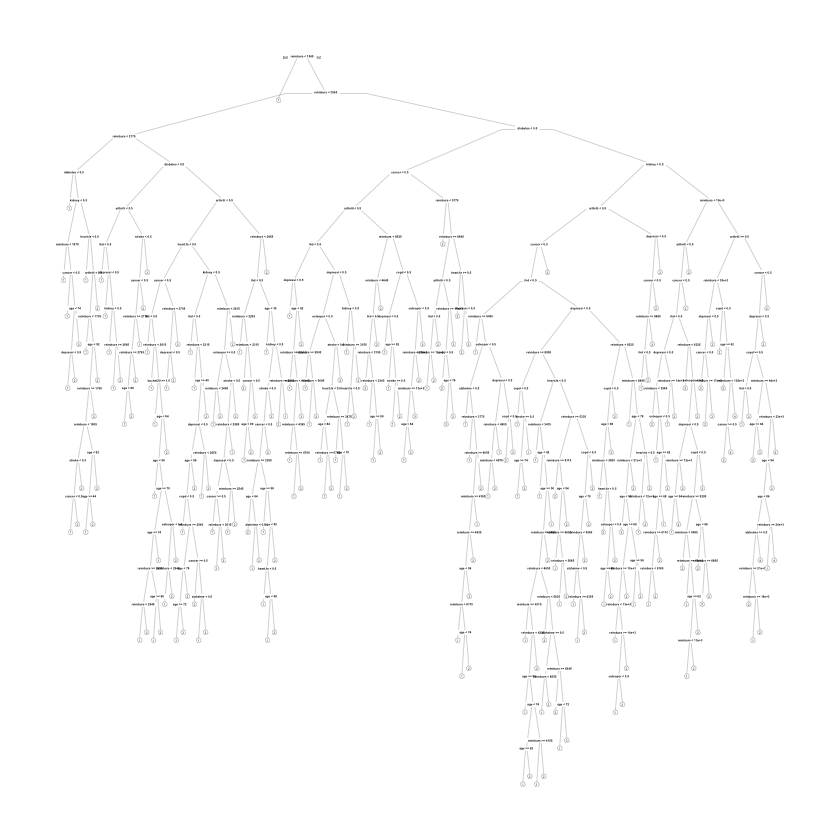

In [59]:
prp(ClaimsTree)

In [60]:
PredictTest = predict(ClaimsTree, newdata=ClaimsTest, type='class')

In [61]:
t = table(ClaimsTest$bucket2009, PredictTest)
sum(diag(t))/sum(t)

[1] 0.7126669

In [62]:
sum(as.matrix(t)*PenaltyMatrix) / nrow(ClaimsTest)

[1] 0.7578902

## Acc increased buy error with penalty goes higher, not good, we need to fit with penalty with "loss"

In [63]:
ClaimsTree = rpart(bucket2009 ~ age + arthritis + alzheimers + cancer +
                  copd + depression + diabetes + heart.failure + ihd + 
                  kidney + osteoporosis + stroke + bucket2008 + reimbursement2008,
                  data=ClaimsTrain,
                  method="class",
                  cp=0.00005,
                  parms=list(loss=PenaltyMatrix))

In [64]:
PredictTest = predict(ClaimsTree, newdata=ClaimsTest, type='class')

In [65]:
t = table(ClaimsTest$bucket2009, PredictTest)
sum(diag(t))/sum(t)

[1] 0.6472746

In [66]:
sum(as.matrix(t)*PenaltyMatrix) / nrow(ClaimsTest)

[1] 0.6418161